In [1]:
#这里的操作同NN_task1_without_mindspore.ipynb，所以就合并到一个cell了
import os
import numpy as np 
import struct
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

#数据预处理
def load_data(path,kind="train"): 
    labels_path=os.path.join(path,"%s-labels.idx1-ubyte"%kind) 
    images_path=os.path.join(path,"%s-images.idx3-ubyte"%kind) 
    with open(labels_path,'rb') as labpath:
        magic_number,item_number=struct.unpack(">II",labpath.read(8)) 
        labels=np.fromfile(labpath,dtype=np.uint8)
    with open(images_path,'rb') as imgpath: 
        magic_number,image_number,rows,cols=struct.unpack(">IIII",imgpath.read(16))
        print(magic_number)
        print(image_number)
        print(rows)
        images=np.fromfile(imgpath,dtype=np.uint8)
    return labels,images 
orig_labels,orig_images=np.array(load_data("./data",kind="train"))
#print("original labels shape is"+str(orig_labels.shape)) 
#print("original images shape is"+str(orig_images.shape))

def get_one_hot(targets,nb_classes):
    return np.eye(nb_classes)[np.array(targets).reshape(-1)] 

images=orig_images.reshape(60000,784)/255  ##注意此处是先将orig_image先reshape成（60000，784）若是改成（784，60000）就会变成乱码
 
images=images.T 

#print(images.shape)

#因为输出层是softmax，因此需要将labels先进⾏one-hot编码
mid_labels=get_one_hot(orig_labels,10)##the mid_labels shape is (60000,10) 
labels=mid_labels.T###the labels shape is (10,60000)


orig_test_labels,orig_test_images=np.array(load_data("./data",kind="t10k"))

test_images=orig_test_images.reshape(10000,784)/255 
test_images=test_images.T 
mid_test_labels=get_one_hot(orig_test_labels,10) 
test_labels=mid_test_labels.T

#NN&BP
np.random.seed(1)
#初始化隐藏层
def initializer_with_hidden_layers(num_hidden_units): 
    w1=np.random.randn(num_hidden_units,784) 
    b1=np.zeros((num_hidden_units,1)) 
    w2=np.random.randn(10,num_hidden_units) 
    b2=np.zeros((10,1))
    parameters={"w1":w1, "b1":b1,"w2":w2,"b2":b2}
    return parameters
def sigmoid(z): 
    s=1/(1+np.exp(-z)) 
    return s
def softmax(z): 
    total=np.sum(np.exp(z),axis=0,keepdims=True) 
    s=np.exp(z)/total
    return s

#定义前向传播函数，并且返回每⼀层当中激活函数的输出  
def forward_propagation(input_x,output_y,parameters): 
    #print("input shape:",input_x.shape)
    m=input_x.shape[1]
    w1=parameters["w1"] 
    #print("w1 shape:",w1.shape)
    b1=parameters["b1"] 
    w2=parameters["w2"] 
    b2=parameters["b2"] 
    a1=sigmoid(np.dot(w1,input_x)+b1) 
    a2=softmax(np.dot(w2,a1)+b2)
    #print("a1.shape:",a1.shape)
    #print("a2.shape:",a2.shape)
    #归一化后的交叉损失熵
    value_cost=0
    value_cost=-1/m*np.sum(output_y*np.log(a2))
    return a1,a2,value_cost

#定义后向传播过程
def backward_propagation(input_x,output_y,parameters,learning_rate,iterations): 
    m=input_x.shape[1]
    w1=parameters["w1"] 
    b1=parameters["b1"] 
    w2=parameters["w2"] 
    b2=parameters["b2"] 
    cost_list = []
    acc_list = []
    # 定义Adam优化器参数
    beta1 = 0.9
    beta2 = 0.999
    epsilon = 1e-8
    m_w1 = np.zeros_like(w1)
    v_w1 = np.zeros_like(w1)
    m_b1 = np.zeros_like(b1)
    v_b1 = np.zeros_like(b1)
    m_w2 = np.zeros_like(w2)
    v_w2 = np.zeros_like(w2)
    m_b2 = np.zeros_like(b2)
    v_b2 = np.zeros_like(b2)
    
    for i in range(iterations):
        a1,a2,cost=forward_propagation(input_x,output_y,parameters) 

        dz2=a2-output_y
        dw2=1/m*np.dot(dz2,a1.T) 
        db2=1/m*np.sum(dz2,axis=1,keepdims=True) 
        dz1=1/m*np.dot(w2.T,dz2)*a1*(1-a1)
        dw1=1/m*np.dot(dz1,input_x.T) 
        db1=1/m*np.sum(dz1,axis=1,keepdims=True) 
        
        
         # 使用Adam优化器更新参数
        m_w1 = beta1 * m_w1 + (1 - beta1) * dw1
        v_w1 = beta2 * v_w1 + (1 - beta2) * (dw1**2)
        m_b1 = beta1 * m_b1 + (1 - beta1) * db1
        v_b1 = beta2 * v_b1 + (1 - beta2) * (db1**2)
        m_w2 = beta1 * m_w2 + (1 - beta1) * dw2
        v_w2 = beta2 * v_w2 + (1 - beta2) * (dw2**2)
        m_b2 = beta1 * m_b2 + (1 - beta1) * db2
        v_b2 = beta2 * v_b2 + (1 - beta2) * (db2**2)
        
         # 进行参数更新
        w1 -= learning_rate * m_w1 / (np.sqrt(v_w1) + epsilon)
        b1 -= learning_rate * m_b1 / (np.sqrt(v_b1) + epsilon)
        w2 -= learning_rate * m_w2 / (np.sqrt(v_w2) + epsilon)
        b2 -= learning_rate * m_b2 / (np.sqrt(v_b2) + epsilon)
        
        assert(w1.shape==dw1.shape) 
        assert(b1.shape==db1.shape) 
        assert(w2.shape==dw2.shape) 
        assert(b2.shape==db2.shape)
        y_predict=np.eye(10)[np.array(a2.argmax(0))].T##这是⽤与one-hot编码     
        acc=1-np.sum(np.abs(y_predict-output_y))/(2*m) 
        
        print("epoch["+str(i+1)+"/"+str(iterations)+"] "+"loss :"+str(cost)+" acc :"+str(acc)) 
        
        cost_list.append(cost)
        acc_list.append(acc)
        parameters={"w1":w1, "b1":b1,"w2":w2,"b2":b2}
        
        

    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()  # 创建右侧y轴
    ax1.plot(range(1, iterations+1), cost_list, color='red', label='Cost')
    ax2.plot(range(1, iterations+1), acc_list, color='blue', label='Accuracy')
    ax1.set_ylabel('Cost')
    ax1.set_xlabel('Epochs')
    ax1.set_title('Cost and Accuracy')
    ax2.set_ylabel('Accuracy')
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    plt.show()

    return parameters

def predict(input_x,output_y,parameters): 
    #m=output_y.shape[1]
    _,y_hat,_ =forward_propagation(input_x,output_y,parameters)
    y_predict=np.eye(10)[np.array(y_hat.argmax(0))]
    #print("shape:",y_predict.shape)
    return y_predict.T

def accuracy(y_predict,output_y): 
    assert(y_predict.shape==output_y.shape) 
    m=output_y.shape[1]
#     print(y_predict)
#     print(output_y)
#     print(np.sum(np.abs(y_predict-output_y)))
#     print(m)
    acc=1-np.sum(np.abs(y_predict-output_y))/(2*m) 
    return acc
def model(input_x,output_y,hidden_units,learning_rate,iterations):
    parameters=initializer_with_hidden_layers(hidden_units) 
    parameters=backward_propagation(input_x,output_y,parameters,learning_rate,iterations)
    y_prediction=predict(input_x,output_y,parameters) 
    acc=accuracy(y_prediction,output_y)
    print("the training-set accuracy is"+str(acc)) 
    return parameters





2051
60000
28
2051
10000
28


epoch[1/100] loss :33.588101820890046 acc :0.11958333333333337
epoch[2/100] loss :20.397305326876534 acc :0.2168
epoch[3/100] loss :24.92555294011403 acc :0.1655333333333333
epoch[4/100] loss :22.822739861787003 acc :0.36793333333333333
epoch[5/100] loss :21.661089615873546 acc :0.5132
epoch[6/100] loss :20.192551236082547 acc :0.6021333333333334
epoch[7/100] loss :19.008660196713272 acc :0.6565833333333333
epoch[8/100] loss :17.35019083856588 acc :0.6777
epoch[9/100] loss :14.630059743271376 acc :0.71275
epoch[10/100] loss :11.958562069338702 acc :0.7202333333333333
epoch[11/100] loss :8.738260954010704 acc :0.7321833333333334
epoch[12/100] loss :5.102925445120312 acc :0.7890666666666667
epoch[13/100] loss :3.1142019948728428 acc :0.84365
epoch[14/100] loss :2.943058662588997 acc :0.8431
epoch[15/100] loss :3.943852212778441 acc :0.8107333333333333
epoch[16/100] loss :5.361128898757125 acc :0.7735166666666666
epoch[17/100] loss :5.860347168814674 acc :0.76385
epoch[18/100] loss :4.972

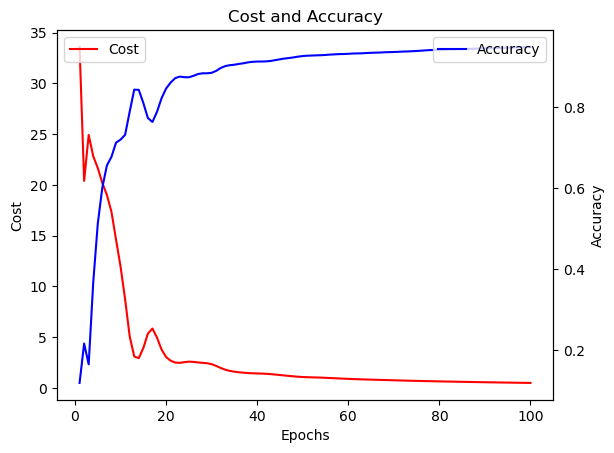

the training-set accuracy is0.9495333333333333
the testing-set accuracy is0.9356


In [2]:
parameters=model(images,labels,hidden_units=1024,learning_rate=0.01,iterations=100)
test_y_prediction=predict(test_images,test_labels,parameters) 
test_accuracy=accuracy(test_y_prediction,test_labels)
print("the testing-set accuracy is"+str(test_accuracy))

epoch[1/200] loss :32.077777672290395 acc :0.09584999999999999
epoch[2/200] loss :23.665574952272067 acc :0.12691666666666668
epoch[3/200] loss :26.214550340377613 acc :0.16983333333333328
epoch[4/200] loss :29.30982932466416 acc :0.18656666666666666
epoch[5/200] loss :12.25892505391768 acc :0.44081666666666663
epoch[6/200] loss :12.478096068006636 acc :0.5499666666666667
epoch[7/200] loss :12.16597520628344 acc :0.6154999999999999
epoch[8/200] loss :10.592154868319454 acc :0.6716666666666666
epoch[9/200] loss :9.149522370503933 acc :0.6836
epoch[10/200] loss :7.9686505398077765 acc :0.6770833333333333
epoch[11/200] loss :5.635599799290617 acc :0.74325
epoch[12/200] loss :5.298603416737247 acc :0.7646
epoch[13/200] loss :5.642826213634093 acc :0.75785
epoch[14/200] loss :5.560917889653252 acc :0.7628333333333334
epoch[15/200] loss :4.8471123621195025 acc :0.7843833333333333
epoch[16/200] loss :3.9489626125061243 acc :0.8146666666666667
epoch[17/200] loss :3.479508371143789 acc :0.83533

epoch[139/200] loss :0.3732218357585136 acc :0.9582166666666667
epoch[140/200] loss :0.3697602767352416 acc :0.9584833333333334
epoch[141/200] loss :0.36634463269031586 acc :0.9587
epoch[142/200] loss :0.3629739489924029 acc :0.95895
epoch[143/200] loss :0.3596475344638367 acc :0.9592833333333334
epoch[144/200] loss :0.356364830213306 acc :0.9594666666666667
epoch[145/200] loss :0.3531251566150954 acc :0.95975
epoch[146/200] loss :0.34992758994069495 acc :0.9600166666666666
epoch[147/200] loss :0.3467710749688866 acc :0.9602333333333334
epoch[148/200] loss :0.34365466377775533 acc :0.9604333333333334
epoch[149/200] loss :0.3405776802708722 acc :0.9605833333333333
epoch[150/200] loss :0.33753969153124014 acc :0.9608166666666667
epoch[151/200] loss :0.3345403256847549 acc :0.9610833333333333
epoch[152/200] loss :0.33157908405911934 acc :0.9613666666666667
epoch[153/200] loss :0.32865528408702904 acc :0.9615833333333333
epoch[154/200] loss :0.3257681586932741 acc :0.9617833333333333
epoch

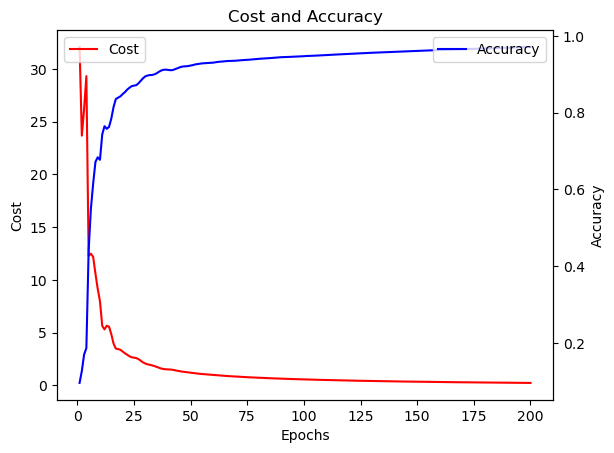

the training-set accuracy is0.9713833333333334
the testing-set accuracy is0.9410000000000001


In [3]:
parameters=model(images,labels,hidden_units=1024,learning_rate=0.01,iterations=200)
test_y_prediction=predict(test_images,test_labels,parameters) 
test_accuracy=accuracy(test_y_prediction,test_labels)
print("the testing-set accuracy is"+str(test_accuracy))
